In [1]:
import numpy as np
from PIL import Image, ImageFilter
from skimage.transform import hough_circle, hough_circle_peaks

skimage의 경우, hough algorithm을 직접 구현하려 하였으나, 최적화 문제 등으로 오래 걸려 import함

In [2]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.filter(ImageFilter.GaussianBlur(radius=2))  # Apply Gaussian blur for noise reduction
    return image


In [3]:
def histogram_equalization(image):
    histogram, bins = np.histogram(np.array(image).flatten(), 256, density=True)
    cumulative_distribution = histogram.cumsum()
    cumulative_distribution = 255 * cumulative_distribution / cumulative_distribution[-1]

    equalized_image = np.interp(image, bins[:-1], cumulative_distribution)
    result = Image.fromarray(equalized_image.astype(np.uint8).reshape((image.size[1], image.size[0])))
    return result


In [4]:
def sobel_filter(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2], 
                        [-1, 0, 1]])    
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    gradient_x = image.filter(ImageFilter.Kernel((3, 3), sobel_x.flatten() ,1,0))
    gradient_y = image.filter(ImageFilter.Kernel((3, 3), sobel_y.flatten(),1,0))

    # gradient_x = np.abs(image.filter(ImageFilter.Kernel((3, 3), sobel_x)))

    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    
    result = gradient_magnitude.reshape((image.size[1], image.size[0]))
    result = gradient_magnitude.astype(np.uint8)
    result = Image.fromarray(result)
    return result


In [5]:
def laplace_filter(image):
    laplace = np.array([[-1, -1, -1],
                        [-1, 8, -1],
                        [-1, -1, -1]])

    gradient = image.filter(ImageFilter.Kernel((3, 3), laplace.flatten() ,1,0))

    return gradient

In [6]:
def binarize_image(image, threshold):
    image = np.array(image)
    return Image.fromarray(((image > threshold)*255).astype(np.uint8))

In [7]:
def find_circle(image):
    # hough Transform
    img_array=np.array(image)
    h, w = image.height, image.width
    min_radius = 10
    max_radius = int(min(w, h)//2)
    circles = hough_circle(img_array, np.arange(min_radius, max_radius, 2))
    """accumulator = np.zeros((h, w, max_radius - min_radius + 1), dtype=int)

    for y in range(h):
        for x in range(w):
            if img_array[y, x] > 0:
                for r in range(min_radius, max_radius + 1):
                    for theta in range(0, 360):
                        a = int(x - r * np.cos(np.deg2rad(theta)))
                        b = int(y - r * np.sin(np.deg2rad(theta)))

                        if a >= 0 and a < w and b >= 0 and b < h:
                            accumulator[b, a, r - min_radius] += 1

    # Find the circles with sufficient votes
    for y in range(h):
        for x in range(w):
            for r in range(min_radius, max_radius + 1):
                if accumulator[y, x, r - min_radius] > 0.9 * accumulator.max():
                    circles.append((x, y, r))

    accumulator = np.zeros """
    # find coin circle
    # blackout surrounding background
    _, x, y, r = hough_circle_peaks(circles, np.arange(min_radius, max_radius, 2),
                                           total_num_peaks=100)
    radind= r.argsort()[::-1]
    x = x[radind]
    y = y[radind]
    r = r[radind]
    coin_regions = []
    for i in range(100):
        coin_region = image.crop((x[i] - r[i], y[i] - r[i], x[i] + r[i], y[i] + r[i]))
        coin_regions.append(coin_region)
    return coin_regions

In [8]:
def pattern_matching(image, pattern):
    
    difference = np.abs(np.array(image) - np.array(pattern))
    if np.mean(difference) < 45:  # should adjust
        return True
    """cosine = np.dot(image,pattern)/(np.linalg.norm(image)*np.linalg.norm(pattern))
    if np.mean(cosine)>0.6:
        return True"""

    return False


In [9]:
def process(image_path):
    image = preprocess_image(image_path)
    image = histogram_equalization(image)
    image = laplace_filter(image)
    image = histogram_equalization(image)
    image = binarize_image(image, 205)
    circles = find_circle(image)
    
    return circles

실 사용을 가정할때 인용 표시를 제거해야 할 것이며, 크기를 줄이는 등의 preprocessing이 필요하다.

In [10]:
coin_pattern_10 = process("coin_template/10.jpeg")[0]
"""coin_pattern_10_2 = process("coin_template/10_2.jpeg")[0]
coin_pattern_50 = process("coin_template/50.jpg")[0]
coin_pattern_50_2 = process("coin_template/50_2.png")[0]"""
coin_pattern_100 = process("coin_template/100.jpg")[0]
"""coin_pattern_100_2 = process("coin_template/100_2.png")[0]
coin_pattern_500 = process("coin_template/500.png")[0]
coin_pattern_500_2 = process("coin_template/500_2.png")[0]"""

'coin_pattern_100_2 = process("coin_template/100_2.png")[0]\ncoin_pattern_500 = process("coin_template/500.png")[0]\ncoin_pattern_500_2 = process("coin_template/500_2.png")[0]'

TODO : 미리 FEATURE를 추출해두기?

In [11]:
def detect_coins(image_path):
    coin_count = [0 for _ in range(4)]
    circles = process(image_path)
   
    for circle in circles:
        circle0 = circle.resize(coin_pattern_10.size)
        circle2 = circle.resize(coin_pattern_100.size)
        if pattern_matching(circle0, coin_pattern_10) : # or pattern_matching(circle, coin_pattern_10_2)
            print("10won Coin detected!")
            coin_count[0]+=1
        """elif pattern_matching(circle1, coin_pattern_50) or pattern_matching(circle, coin_pattern_50_2):
            print("50won Coin detected!")
            coin_count[1]+=1"""
        if pattern_matching(circle2, coin_pattern_100): #or pattern_matching(circle, coin_pattern_100_2):
            print("100won Coin detected!")
            coin_count[2]+=1
        """elif pattern_matching(circle3, coin_pattern_500)or pattern_matching(circle, coin_pattern_500_2):
            print("500won Coin detected!")
            coin_count[3]+=1"""
    return coin_count 

    # Load the pattern image of a coin to match against   



Test

In [12]:
image_path = ("image/1.jpg")

image = process(image_path)



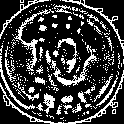

In [13]:
image[15].show()

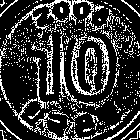

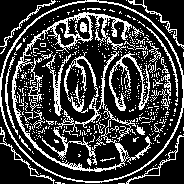

In [14]:
coin_pattern_10.show()
coin_pattern_100.show()

In [15]:
detect_coins("image/1.jpg")

10won Coin detected!


[1, 0, 0, 0]